# End-to-End example
## Computing Niño 3.4 Index
---
In this notebook, we are going to combine all concepts/topics we've covered so far to compute [Niño 3.4 Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) for the CESM2 submission for [CMIP6 project](https://esgf-node.llnl.gov/projects/cmip6/). 


> Niño 3.4 (5N-5S, 170W-120W): The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.


![](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)


At the end of this notebook, you should be able to produce a plot that looks similar [to this one](https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/indices_oni_2_2_lg.png?itok=61jS7Jz7)

![](https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/indices_oni_2_2_lg.png?itok=61jS7Jz7)


---

## Learning Objectives 


- Load data
- Masking data using `.where()` method
- Compute climatologies and anomalies using `.groupby()`
- Use `.rolling()` to compute moving average
- Normalize computed  Niño 3.4 Index 
- Visualize the computed  Niño 3.4 Index 

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](./xarray.ipynb) | Necessary | |
| [Computation and Masking](./computation-masking.ipynb) | Necessary | |



- **Time to learn**: 20 minutes

---

## Task 1: Import packages 


In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr

## Task 2: Open the sea surface temperature dataset and the areacello

In [2]:
data = xr.open_dataset(
    "./data/tos_Omon_CESM2_historical_r11i1p1f1_gr_200001-201412.nc", engine="netcdf4"
)
areacello = xr.open_dataset(
    "./data/areacello_Ofx_CESM2_historical_r11i1p1f1_gr.nc", engine="netcdf4"
)

# Merge the two datasets in a single dataset
ds = xr.merge([data, areacello])
ds

/home/rf194656/anaconda3/envs/pythia-book-dev/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360, lev: 33)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lev        (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 -90.0 -89.0 -89.0 -88.0 ... 88.0 89.0 89.0 90.0
    lon_bnds   (lon, d2) float64 0.0 1.0 1.0 2.0 2.0 ... 358.0 359.0 359.0 360.0
    tos        (time, lat, lon) float32 ...
    lev_bnds   (lev, d2) float64 ...
    areacello  (lat, lon) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

## Task 3: Visualize the first time slice to make sure the data looks okay

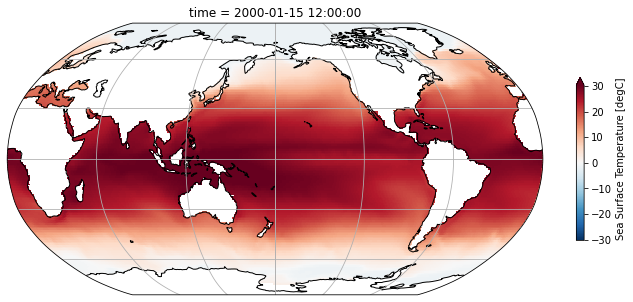

In [3]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ds.tos.isel(time=0).plot(
    robust=True, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}
)
ax.set_global()

## Task 4: Select the Niño 3.4 region 

There are a few ways for selecting the Niño 3.4 region

1. Use `sel()` or `isel()`
2. Use `where()` and select all vlaues within the bounds of interest

In [4]:
tos_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))
tos_nino34

<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50, lev: 33)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
  * lev        (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object 2000-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (lat, d2) float64 -5.0 -4.0 -4.0 -3.0 -3.0 ... 3.0 4.0 4.0 5.0
    lon_bnds   (lon, d2) float64 190.0 191.0 191.0 192.0 ... 239.0 239.0 240.0
    tos        (time, lat, lon) float32 ...
    lev_bnds   (lev, d2) float64 0.0 5.0 5.0 15.0 ... 5.25e+03 5.25e+03 5.5e+03
    areacello  (lat, lon) float64 1.233e+10 1.233e+10 ... 1.233e+10 1.233e+10
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

Another option for selecting our region of interest is to use:

In [5]:
# tos_nino34 = ds.where((ds.lat<5) & (ds.lat>-5) & (ds.lon>190) & (ds.lon<240), drop=True)

Let's plot the selected region to make sure we are doing the right thing:

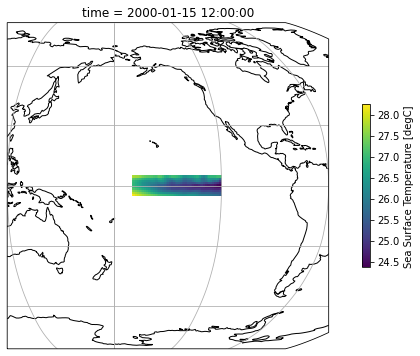

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
tos_nino34.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}
)
ax.set_extent((120, 300, 10, -10))

## Task 5: Compute monthly climatology for area averaged total SST from Niño 3.4 region, and subtract climatology from area averaged total SST time series to obtain anomalies;



In [7]:
gb = tos_nino34.tos.groupby('time.month')
tos_nino34_anom = gb - gb.mean(dim='time')
index_nino34 = tos_nino34_anom.weighted(tos_nino34.areacello).mean(dim=['lat', 'lon'])

## Task 6: Smooth the anomalies with a 5-month running mean

In [8]:
index_nino34_rolling_mean = index_nino34.rolling(time=5).mean()

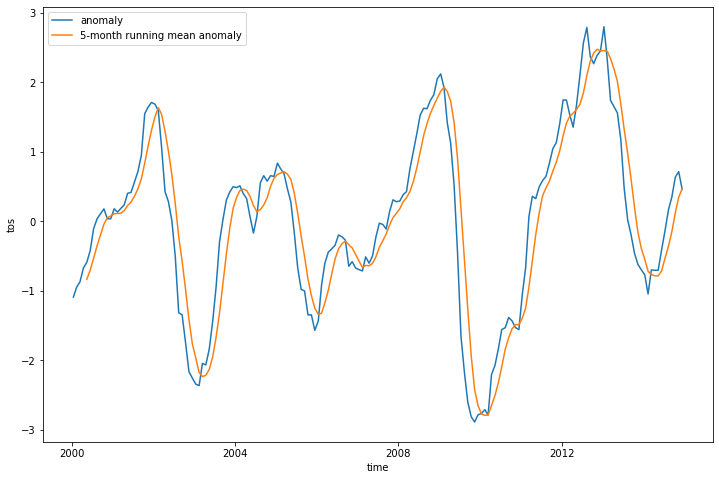

In [9]:
index_nino34.plot(size=8)
index_nino34_rolling_mean.plot()
plt.legend(['anomaly', '5-month running mean anomaly']);

## Task 7: Normalize the smoothed values by its standard deviation over the climatological period

In [10]:
std_dev = tos_nino34.tos.std()
std_dev

<xarray.DataArray 'tos' ()>
array(1.8436452, dtype=float32)

In [11]:
normalized_index_nino34_rolling_mean = index_nino34_rolling_mean / std_dev

## Visualize the computed Niño 3.4


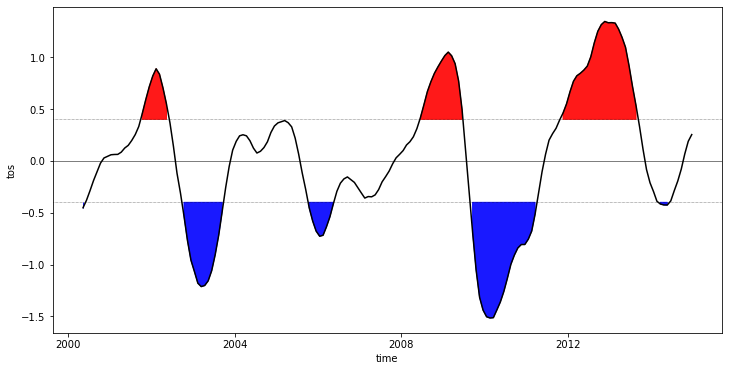

In [12]:
fig = plt.figure(figsize=(12, 6))

# Add -0.4/+0.4 lines which are the El Niño 3.4 thresholds
plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean >= 0.4
    ).data,
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean <= -0.4
    ).data,
    -0.4,
    color='blue',
    alpha=0.9,
)

normalized_index_nino34_rolling_mean.plot(color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted');

---

## Resources and References

- [Project Pythia Resource Gallery](https://projectpythia.org/gallery.html)
- [Pangeo Gallery](http://gallery.pangeo.io/)